In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import pickle
import cvxpy as cvx
from scipy.special import softmax, expit, logsumexp

#### Load deep ensemble

Ensemble dimensions:

In [2]:
# Number of models in ensemble
M = 5
# Number of hidden layers
L = 2

Load NN weights:

In [3]:
w = []
b = []

# Iterate over models
for m in range(M):
    W = np.load("robust_mnist2x10.npz")

    # Put weights into list of arrays
    w.append([None] * (L + 1))
    b.append([None] * (L + 1))
    for ll in range(L + 1):
        w[m][ll] = W['w' + str(ll + 1)]
        b[m][ll] = W['b' + str(ll + 1)]

#w0 = W["w1"]
#b0 = W["b1"]
#w1 = W["w2"]
#b1 = W["b2"]
#w2 = W["w3"]
#b2 = W["b3"]

In [4]:
for m in range(M):
    print(len(w[m]))
    print([ww.shape for ww in w[m]])

3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]
3
[(784, 10), (10, 10), (10, 10)]


#### Load MNIST test images and bounds:

In [5]:
(X, y), (Xt, yt) = mnist.load_data()

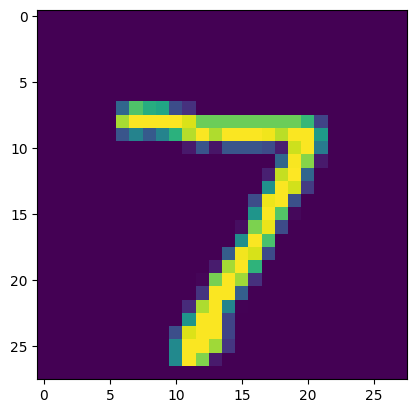

In [6]:
plt.imshow(Xt[0])
plt.show()

Perturbation radius:

In [7]:
eps = 0.08

Load neuron bounds:

In [8]:
with open(f"./bounds/bounds_ind0_eps{eps}.pickle", 'rb') as fp:
    bounds = pickle.load(fp)
lbs = bounds["lbs"]
ubs = bounds["ubs"]

#### Input layer

In [9]:
mid0 = Xt[0].flatten() / 255

In [10]:
# Input bounds
l0 = np.maximum(mid0 - eps, 0)
u0 = np.minimum(mid0 + eps, 1)

In [11]:
# Check that just computed bounds are close to loaded ones
np.abs(u0 - np.array(ubs[0])).max()

4.901960784314818e-05

In [12]:
D = len(mid0)
x0 = cvx.Variable(D)

In [13]:
# Initialize list of constraints
cons = [x0 >= l0, x0 <= u0]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,)))]

#### Hidden layers

In [14]:
# Initialize lists of quantities over models
z = [None] * M
xa = [None] * M
xu = [None] * M
l = [None] * M
u = [None] * M
inactive = [None] * M
active = [None] * M
unstable = [None] * M

In [15]:
# Iterate over models
for m in range(M):
    # Initialize lists over layers
    z[m] = [None] * (L + 1)
    xa[m] = [None] * L
    xu[m] = [None] * L
    l[m] = [None] * (L + 1)
    u[m] = [None] * (L + 1)
    inactive[m] = [None] * L
    active[m] = [None] * L
    unstable[m] = [None] * L
    
    # Iterate over hidden layers
    for ll in range(L):
        # Bounds on pre-activation neurons
        l[m][ll] = np.array(lbs[2*ll+1])
        u[m][ll] = np.array(ubs[2*ll+1])
        #print(l[m][ll], u[m][ll])

        # Drop inactive neurons
        inactive[m][ll] = u[m][ll] <= 0
        w[m][ll] = w[m][ll][:, ~inactive[m][ll]]
        b[m][ll] = b[m][ll][~inactive[m][ll]]
        l[m][ll] = l[m][ll][~inactive[m][ll]]
        u[m][ll] = u[m][ll][~inactive[m][ll]]
        w[m][ll+1] = w[m][ll+1][~inactive[m][ll], :]
        #print(w[m][ll].shape, b[m][ll].shape, w[m][ll+1].shape)
        #print(l[m][ll], u[m][ll])

        # Find unstable and active neurons
        unstable[m][ll] = l[m][ll] < 0
        active[m][ll] = ~unstable[m][ll]
        #print(active[m][ll], unstable[m][ll])

        # Affine transformation
        if ll == 0:
            # Input layer
            z[m][ll] = x0 @ w[m][ll] + b[m][ll]
        else:
            z[m][ll] = xa[m][ll-1] @ w[m][ll][active[m][ll-1], :] + xu[m][ll-1] @ w[m][ll][unstable[m][ll-1], :] + b[m][ll]
        
        # Define active neurons
        #xa[ll] = xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], active[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], active[ll])] + b[ll-1][active[ll]]
        xa[m][ll] = z[m][ll][active[m][ll]]

        # Define and constrain unstable neurons
        xu[m][ll] = cvx.Variable(unstable[m][ll].sum(), nonneg=True)
        #cons.append( xu[ll] >= xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], unstable[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], unstable[ll])] + b[ll-1][unstable[ll]] )
        cons.append(xu[m][ll] >= z[m][ll][unstable[m][ll]])
        g = u[m][ll][unstable[m][ll]] / (u[m][ll][unstable[m][ll]] - l[m][ll][unstable[m][ll]])
        #cons.append( xu[ll] <= cvx.multiply(g, xa[ll-1] @ w[ll-1][np.ix_(active[ll-1], unstable[ll])] + xu[ll-1] @ w[ll-1][np.ix_(unstable[ll-1], unstable[ll])] + b[ll-1][unstable[ll]] - l[ll][unstable[ll]]) )
        cons.append(xu[m][ll] <= cvx.multiply(g, z[m][ll][unstable[m][ll]] - l[m][ll][unstable[m][ll]]))

cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True))]

In [16]:
xa, xu

([[Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (5,))],
  [Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (5,))],
  [Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (5,))],
  [Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (5,))],
  [Expression(AFFINE, UNKNOWN, (6,)), Expression(AFFINE, UNKNOWN, (5,))]],
 [[Variable((3,), nonneg=True), Variable((4,), nonneg=True)],
  [Variable((3,), nonneg=True), Variable((4,), nonneg=True)],
  [Variable((3,), nonneg=True), Variable((4,), nonneg=True)],
  [Variable((3,), nonneg=True), Variable((4,), nonneg=True)],
  [Variable((3,), nonneg=True), Variable((4,), nonneg=True)]])

#### Logits

In [17]:
# Iterate over models
for m in range(M):
    z[m][L] = xa[m][L-1] @ w[m][L][active[m][L-1], :] + xu[m][L-1] @ w[m][L][unstable[m][L-1], :] + b[m][L]
z

[[Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))],
 [Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (9,)),
  Expression(AFFINE, UNKNOWN, (10,))]]

In [18]:
# Bounds on logits
for m in range(M):
    l[m][L] = np.array(lbs[2*L+1])
    u[m][L] = np.array(ubs[2*L+1])
#l2 = np.array(lbs[5])
#u2 = np.array(ubs[5])
#l, u

In [19]:
# Index of largest logit in terms of midpoint
jmax = np.empty(M, dtype=int)
for m in range(M):
    jmax[m] = (l[m][L] + u[m][L]).argmax()
jmax

array([7, 7, 7, 7, 7])

#### Softmax

In [20]:
LBtype = 'LSE'
UBtype = 'LSE'

In [21]:
# Number of classes
d = 10

# Output probabilities
p = cvx.Variable((M, d), nonneg=True)

Load and compute bounds:

In [22]:
# Bounds on logit differences
diffs_l = np.empty((M, d, d-1))
diffs_u = np.empty((M, d, d-1))
# Bounds on probabilities
sm_l = np.empty((M, d))
sm_u = np.empty((M, d))
if UBtype == 'LSE':
    lsm_l = np.empty((M, d))
    lsm_u = np.empty((M, d))

# Iterate over models
for m in range(M):
    # Iterate over classes
    for j in range(d):
        # Bounds on logit differences z_{j'} - z_j
        diffs_l[m, j] = np.array(lbs[6])[(d-1)*j:(d-1)*(j+1)]
        diffs_u[m, j] = np.array(ubs[6])[(d-1)*j:(d-1)*(j+1)]
        # Constant bounds on softmax output
        sm_l[m, j] = expit(-logsumexp(diffs_u[m, j]))
        sm_u[m, j] = expit(-logsumexp(diffs_l[m, j]))
        if UBtype == 'LSE':
            # Also need log of constant bounds
            lsm_l[m, j], lsm_u[m, j] = np.log(sm_l[m, j]), np.log(sm_u[m, j])


In [23]:
print(sm_l)
print(sm_u)

[[4.85158749e-07 2.75765368e-07 7.97060862e-06 2.43861283e-05
  1.66438523e-06 1.10356091e-06 1.02594824e-09 9.63653513e-01
  9.12210043e-08 1.11051326e-04]
 [4.85158749e-07 2.75765368e-07 7.97060862e-06 2.43861283e-05
  1.66438523e-06 1.10356091e-06 1.02594824e-09 9.63653513e-01
  9.12210043e-08 1.11051326e-04]
 [4.85158749e-07 2.75765368e-07 7.97060862e-06 2.43861283e-05
  1.66438523e-06 1.10356091e-06 1.02594824e-09 9.63653513e-01
  9.12210043e-08 1.11051326e-04]
 [4.85158749e-07 2.75765368e-07 7.97060862e-06 2.43861283e-05
  1.66438523e-06 1.10356091e-06 1.02594824e-09 9.63653513e-01
  9.12210043e-08 1.11051326e-04]
 [4.85158749e-07 2.75765368e-07 7.97060862e-06 2.43861283e-05
  1.66438523e-06 1.10356091e-06 1.02594824e-09 9.63653513e-01
  9.12210043e-08 1.11051326e-04]]
[[3.95253078e-03 2.61973402e-04 2.75567797e-03 9.99404486e-03
  2.08911714e-03 2.51198846e-03 1.64052423e-05 9.99852686e-01
  2.03718425e-04 1.54540578e-02]
 [3.95253078e-03 2.61973402e-04 2.75567797e-03 9.99404486

Constrain softmax outputs:

In [24]:
# Iterate over models
diffs = [None] * M
for m in range(M):
    # Iterate over classes
    for j in range(d):

        # Add constraint on jth softmax output
        if j == yt[0]:
            # Correct class, need lower bound on probability
            if LBtype == 'ER' or j == jmax[m]:
                # LSE2 bound same as ER bound when j = jmax
                # Differences with z_j
                others = np.arange(d) != j
                diffs[m] = z[m][L][others] - z[m][L][j]
                #cons += [diffs[j] >= diffs_l[j], diffs[j] <= diffs_u[j]]
                #bnd = p[j] >= cvx.power(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])), -1)
                # Bounding log probability avoids having to use a second-order cone
                bnd = cvx.log(p[m, j]) >= -cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[m, j]), diffs_u[m, j] - diffs[m]) + cvx.multiply(np.exp(diffs_u[m, j]), diffs[m] - diffs_l[m, j])) / (diffs_u[m, j] - diffs_l[m, j])))
            elif LBtype == 'LSE':
                # LSE2 bound for j != jmax
                # Differences with z_{jmax}
                others = np.arange(d) != jmax[m]
                diffs[m] = z[m][L] - z[m][L][jmax[m]]
                bnd = cvx.log(p[m, j]) >= diffs[m][j] - cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[m, jmax[m]]), diffs_u[m, jmax[m]] - diffs[m][others]) + cvx.multiply(np.exp(diffs_u[m, jmax[m]]), diffs[m][others] - diffs_l[m, jmax[m]])) / (diffs_u[m, jmax[m]] - diffs_l[m, jmax[m]])))
        else:
            # Incorrect class, need upper bound on probability
            if UBtype == 'ER':
                # CAN'T USE: HAVING MORE THAN 2 OF THESE BOUNDS PREVENTS CONVERGENCE 
                #bnd = p[j] <= sm_l[j] + sm_u[j] - sm_l[j] * sm_u[j] * (1 + cvx.sum(cvx.exp(diffs[j])))
                bnd = p[m, j] <= sm_l[m, j] + sm_u[m, j] - sm_l[m, j] * sm_u[m, j] * cvx.exp(cvx.log_sum_exp(z[m][L]) - z[m][L][j])
            elif UBtype == 'LSE':
                bnd = p[m, j] <= (lsm_u[m, j] * sm_l[m, j] - lsm_l[m, j] * sm_u[m, j] - (sm_u[m, j] - sm_l[m, j]) * (cvx.log_sum_exp(z[m][L]) - z[m][L][j])) / (lsm_u[m, j] - lsm_l[m, j])
        cons.append(bnd)

    # Sum to 1 constraint
    cons.append(cvx.sum(p[m, :]) == 1)

In [25]:
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Exp

#### Score function upper bound (use only one of the following)

Negative log-likelihood: equivalently minimize probability of correct class

In [26]:
#score_ub = -p[yt[0]]
score_ub = -cvx.sum(p[:, yt[0]]) / M

Brier score: linear upper bound

In [37]:
others = np.arange(d) != yt[0]
score_ub = -(2 - sm_l[:, yt[0]].mean() - sm_u[:, yt[0]].mean()) * cvx.sum(p[:, yt[0]]) / M + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ cvx.sum(p[:, others], axis=0) / M - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

In [38]:
score_ub

Expression(AFFINE, UNKNOWN, ())

#### Solve problem

In [39]:
prob = cvx.Problem(cvx.Maximize(score_ub), cons)

In [40]:
#prob.solve(solver='SCS', verbose=True, acceleration_lookback=0, max_iters=int(1e4))
prob.solve(solver='SCS', verbose=True, acceleration_lookback=0, max_iters=int(1e4), eps=1e-5)

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 453738
eps = 1.00e-05, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
acceleration_lookback = 0, rho_x = 1.00e-03
Variables n = 1374, constraints m = 3203
Cones:	primal zero / dual free vars: 5
	linear vars: 1818
	exp vars: 1380, dual exp vars: 0
Setup time: 2.83e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.43e+20  3.65e+19  1.00e+00 -6.05e+19  3.11e+19  1.57e+20  1.50e-02 
   100| 1.63e-02  2.01e-03  1.39e-03  3.51e-02  3.37e-02  5.79e-18  7.90e-01 
   200| 1.17e-03  9.91e-04  4.15e-04  3.48e-02  3.44e

  9500| 1.07e-05  1.22e-06  2.72e-07  3.49e-02  3.49e-02  2.21e-17  4.50e+01 
  9600| 1.06e-05  2.47e-06  1.67e-07  3.49e-02  3.49e-02  2.21e-17  4.56e+01 
  9700| 1.04e-05  3.88e-06  6.49e-07  3.49e-02  3.49e-02  2.21e-17  4.62e+01 
  9800| 1.05e-05  2.54e-06  2.21e-07  3.49e-02  3.49e-02  4.47e-18  4.68e+01 
  9900| 1.07e-05  1.41e-06  3.31e-07  3.49e-02  3.49e-02  4.87e-17  4.74e+01 
 10000| 1.07e-05  1.55e-06  3.03e-07  3.49e-02  3.49e-02  4.47e-18  4.81e+01 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 4.81e+01s
	Lin-sys: nnz in L factor: 624250, avg solve time: 1.83e-03s
	Cones: avg projection time: 2.83e-03s
	Acceleration: avg step time: 1.94e-07s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 6.0148e-05, dist(y, K*) = 8.8253e-07, s'y/|s||y| = -2.5005e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0653

0.001580829423494079

In [41]:
prob.status

'optimal_inaccurate'

In [42]:
for m in range(2):
    print(np.hstack((l[m][L][:,np.newaxis], z[m][L].value[:,np.newaxis], u[m][L][:,np.newaxis])))

[[ -6.8695      -2.66823844  -0.3324    ]
 [ -8.1546      -5.75991912  -2.7616    ]
 [ -4.6251      -3.29265797  -0.5321    ]
 [ -3.0532      -1.20279567   0.6129    ]
 [ -6.4314      -2.97452178  -0.3173    ]
 [ -5.9146      -2.19367401  -1.1008    ]
 [-13.1974      -8.22427151  -5.8981    ]
 [  3.6956       3.85164736   9.0404    ]
 [ -7.7966      -5.14669678  -4.0264    ]
 [ -2.3943      -0.52871076   1.9851    ]]
[[ -6.8695      -2.66823844  -0.3324    ]
 [ -8.1546      -5.75991912  -2.7616    ]
 [ -4.6251      -3.29265797  -0.5321    ]
 [ -3.0532      -1.20279567   0.6129    ]
 [ -6.4314      -2.97452178  -0.3173    ]
 [ -5.9146      -2.19367401  -1.1008    ]
 [-13.1974      -8.22427151  -5.8981    ]
 [  3.6956       3.85164736   9.0404    ]
 [ -7.7966      -5.14669678  -4.0264    ]
 [ -2.3943      -0.52871076   1.9851    ]]


In [43]:
for m in range(2):
    print(np.hstack((diffs_l[m,yt[0],np.newaxis].T, diffs[m].value[:,np.newaxis], diffs_u[m,yt[0],np.newaxis].T)))

[[-14.538       -6.51988581  -5.5233    ]
 [-15.1008      -9.61156649  -8.2442    ]
 [-11.7364      -7.14430534  -5.8893    ]
 [-10.6185      -5.05444304  -4.5943    ]
 [-13.3047      -6.82616914  -6.1573    ]
 [-13.7164      -6.04532138  -5.9752    ]
 [-20.697      -12.07591888 -11.0069    ]
 [-16.2094      -8.99834414  -8.4918    ]
 [ -9.1037      -4.38035812  -4.1539    ]]
[[-14.538       -6.51988581  -5.5233    ]
 [-15.1008      -9.61156649  -8.2442    ]
 [-11.7364      -7.14430534  -5.8893    ]
 [-10.6185      -5.05444304  -4.5943    ]
 [-13.3047      -6.82616914  -6.1573    ]
 [-13.7164      -6.04532138  -5.9752    ]
 [-20.697      -12.07591888 -11.0069    ]
 [-16.2094      -8.99834414  -8.4918    ]
 [ -9.1037      -4.38035812  -4.1539    ]]


In [44]:
for m in range(2):
    print(np.hstack((sm_l[m,np.newaxis].T, softmax(z[m][L].value)[:,np.newaxis], p.value[m,np.newaxis].T, sm_u[m,np.newaxis].T)))
#np.hstack((sm_l[:,np.newaxis], p.value[:,np.newaxis], softmax(z.value)[:,np.newaxis], sm_u[:,np.newaxis])) 

[[4.85158749e-07 1.43814948e-03 3.46244446e-03 3.95253078e-03]
 [2.75765368e-07 6.53287232e-05 1.58820087e-04 2.61973402e-04]
 [7.97060862e-06 7.70232913e-04 2.10997242e-03 2.75567797e-03]
 [2.43861283e-05 6.22641033e-03 9.16406930e-03 9.99404486e-03]
 [1.66438523e-06 1.05873402e-03 1.84367078e-03 2.08911714e-03]
 [1.10356091e-06 2.31155771e-03 2.43842443e-03 2.51198846e-03]
 [1.02594824e-09 5.55711681e-06 0.00000000e+00 1.64052423e-05]
 [9.63653513e-01 9.75785719e-01 9.66067580e-01 9.99852686e-01]
 [9.12210043e-08 1.20621090e-04 1.39627611e-04 2.03718425e-04]
 [1.11051326e-04 1.22176899e-02 1.46783730e-02 1.54540578e-02]]
[[4.85158749e-07 1.43814948e-03 3.46244446e-03 3.95253078e-03]
 [2.75765368e-07 6.53287232e-05 1.58820087e-04 2.61973402e-04]
 [7.97060862e-06 7.70232913e-04 2.10997242e-03 2.75567797e-03]
 [2.43861283e-05 6.22641033e-03 9.16406930e-03 9.99404486e-03]
 [1.66438523e-06 1.05873402e-03 1.84367078e-03 2.08911714e-03]
 [1.10356091e-06 2.31155771e-03 2.43842443e-03 2.51198

In [35]:
def eval_ER_l(X, diffs_l, diffs_u):
    """
    Evaluate exponential-reciprocal lower bound at points in X (shape (n, d))
    """
    diffs = X[:, np.arange(d)!=yt[0]] - X[:, yt[0]]
    # Coefficients of affine function of diffs
    a_ER_l = (np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)
    b_ER_l = ((diffs_u * np.exp(diffs_l) - diffs_l * np.exp(diffs_u)) / (diffs_u - diffs_l)).sum()
    
    ER_l = 1 / (1 + np.dot(diffs, a_ER_l) + b_ER_l)
    return ER_l


In [36]:
eval_ER_l(z[0][L].value[np.newaxis, :], diffs_l[0,yt[0]], diffs_u[0,yt[0]])

array([0.9662644])

In [45]:
((softmax(z[0][L].value) - (np.arange(d) == yt[0]))**2).sum()

0.0007835161466046611

In [46]:
test = sm_u[0].copy()
test[yt[0]] = sm_l[0, yt[0]]
((test - (np.arange(d) == yt[0]))**2).sum()

0.0016937771020311882

In [863]:
-(2 - sm_l[yt[0]] - sm_u[yt[0]]) * softmax(z.value)[yt[0]] + (sm_l[others] + sm_u[others]) @ softmax(z.value)[others] - np.dot(sm_l, sm_u) + 1 

0.0011441772836467967

In [47]:
-(2 - sm_l[:, yt[0]].mean() - sm_u[:, yt[0]].mean()) * p.value[:, yt[0]].mean() + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ p.value[:, others].mean(axis=0) - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

0.0015808296910743147

In [48]:
-(2 - sm_l[:, yt[0]].mean() - sm_u[:, yt[0]].mean()) * test[yt[0]] + (sm_l[:, others].mean(axis=0) + sm_u[:, others].mean(axis=0)) @ test[others] - np.dot(sm_l.mean(axis=0), sm_u.mean(axis=0)) + 1 

0.0016937771020311132

## OLD

#### Hidden layer 1

In [705]:
l0 = np.array(lbs[1])
u0 = np.array(ubs[1])
l0, u0

(array([-1.2855,  0.6487,  0.5012, -3.622 , -2.8138, -0.5145,  2.1417,
         1.1181,  2.7157,  7.5092]),
 array([ 2.1951,  4.4368,  3.454 , -0.8622,  0.0459,  3.5994,  4.9922,
         4.9872,  6.7239, 10.9493]))

In [706]:
# Drop inactive neurons
inactive0 = u0 <= 0
w0 = w0[:, ~inactive0]
b0 = b0[~inactive0]
l0 = l0[~inactive0]
u0 = u0[~inactive0]

In [707]:
w1 = w1[~inactive0, :]
w1.shape

(9, 10)

In [708]:
w0.shape, b0.shape
l0, u0

(array([-1.2855,  0.6487,  0.5012, -2.8138, -0.5145,  2.1417,  1.1181,
         2.7157,  7.5092]),
 array([ 2.1951,  4.4368,  3.454 ,  0.0459,  3.5994,  4.9922,  4.9872,
         6.7239, 10.9493]))

In [709]:
unstable0 = l0 < 0
active0 = ~unstable0
active0, unstable0

(array([False,  True,  True, False, False,  True,  True,  True,  True]),
 array([ True, False, False,  True,  True, False, False, False, False]))

In [710]:
nActive = active0.sum()
nUnstable = unstable0.sum()
#xa1 = cvx.Variable(nActive)
xu1 = cvx.Variable(nUnstable, nonneg=True)

In [650]:
cons.append(xa1 == x0 @ w0[:, active0] + b0[active0])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,)))]

In [651]:
cons += [xa1 >= l0[active0], xa1 <= u0[active0]]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,)))]

In [711]:
xa1 = x0 @ w0[:, active0] + b0[active0]
xa1

Expression(AFFINE, UNKNOWN, (6,))

In [712]:
cons.append(xu1 >= x0 @ w0[:, unstable0] + b0[unstable0])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,)))]

In [713]:
g0 = u0[unstable0] / (u0[unstable0] - l0[unstable0])
cons.append(xu1 <= cvx.multiply(g0, x0 @ w0[:, unstable0] + b0[unstable0] - l0[unstable0]))
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True))]

#### Hidden layer 2

In [714]:
l1 = np.array(lbs[3])
u1 = np.array(ubs[3])
l1, u1

(array([-0.3692,  1.4975, -6.9588, -1.2922,  5.5931,  2.4842, -1.4013,
         6.9371, -1.712 ,  0.181 ]),
 array([ 3.3785,  4.9457, -2.9962,  1.5076, 11.3816,  6.3993,  1.7474,
        12.2549,  1.71  ,  3.7962]))

In [715]:
# Drop inactive neurons
inactive1 = u1 <= 0
w1 = w1[:, ~inactive1]
b1 = b1[~inactive1]
l1 = l1[~inactive1]
u1 = u1[~inactive1]
w2 = w2[~inactive1, :]

In [716]:
print(w1.shape, b1.shape, w2.shape)
l1, u1

(9, 9) (9,) (9, 10)


(array([-0.3692,  1.4975, -1.2922,  5.5931,  2.4842, -1.4013,  6.9371,
        -1.712 ,  0.181 ]),
 array([ 3.3785,  4.9457,  1.5076, 11.3816,  6.3993,  1.7474, 12.2549,
         1.71  ,  3.7962]))

In [717]:
unstable1 = l1 < 0
active1 = ~unstable1
active1, unstable1

(array([False,  True, False,  True,  True, False,  True, False,  True]),
 array([ True, False,  True, False, False,  True, False,  True, False]))

In [718]:
nActive = active1.sum()
nUnstable = unstable1.sum()
#xa2 = cvx.Variable(nActive)
xu2 = cvx.Variable(nUnstable, nonneg=True)

In [659]:
# indices of active and unstable should be one greater
cons.append(xa2 == xa1 @ w1[np.ix_(active0, active1)] + xu1 @ w1[np.ix_(unstable0, active1)] + b1[active1])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,)))]

In [660]:
cons += [xa2 >= l1[active1], xa2 <= u1[active1]]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,)))]

In [719]:
xa2 = xa1 @ w1[np.ix_(active0, active1)] + xu1 @ w1[np.ix_(unstable0, active1)] + b1[active1]
xa2

Expression(AFFINE, UNKNOWN, (5,))

In [720]:
cons.append(xu2 >= xa1 @ w1[np.ix_(active0, unstable1)] + xu1 @ w1[np.ix_(unstable0, unstable1)] + b1[unstable1])
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,)))]

In [721]:
g1 = u1[unstable1] / (u1[unstable1] - l1[unstable1])
cons.append(xu2 <= cvx.multiply(g1, xa1 @ w1[np.ix_(active0, unstable1)] + xu1 @ w1[np.ix_(unstable0, unstable1)] + b1[unstable1] - l1[unstable1]))
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True))]

#### Logits

In [663]:
z = cvx.Variable(10)

In [613]:
cons = []

In [665]:
cons += [z >= l2, z <= u2]
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,))),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Constant(CONSTANT, UNKNOWN, (10,))),
 Inequality(Variable((10,)))]

In [666]:
cons.append(z == xa2 @ w2[active1, :] + xu2 @ w2[unstable1, :] + b2)
cons

[Inequality(Constant(CONSTANT, NONNEGATIVE, (784,))),
 Inequality(Variable((784,))),
 Equality(Variable((6,)), Expression(AFFINE, UNKNOWN, (6,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (6,))),
 Inequality(Variable((6,))),
 Inequality(Expression(AFFINE, UNKNOWN, (3,))),
 Inequality(Variable((3,), nonneg=True)),
 Equality(Variable((5,)), Expression(AFFINE, UNKNOWN, (5,))),
 Inequality(Constant(CONSTANT, NONNEGATIVE, (5,))),
 Inequality(Variable((5,))),
 Inequality(Expression(AFFINE, UNKNOWN, (4,))),
 Inequality(Variable((4,), nonneg=True)),
 Inequality(Constant(CONSTANT, UNKNOWN, (10,))),
 Inequality(Variable((10,))),
 Equality(Variable((10,)), Expression(AFFINE, UNKNOWN, (10,)))]

#### Score function upper bound

Negative log-likelihood, using LSE lower bound 1:

In [36]:
score_ub = cvx.log(cvx.sum((cvx.multiply(np.exp(l2), u2 - z) + cvx.multiply(np.exp(u2), z - l2)) / (u2 - l2))) - z[yt[0]]

#### Solve problem

In [371]:
j = yt[0]
obj = cvx.power(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])), -1)
#obj = cvx.log(1 + cvx.sum((cvx.multiply(np.exp(diffs_l[j]), diffs_u[j] - diffs[j]) + cvx.multiply(np.exp(diffs_u[j]), diffs[j] - diffs_l[j])) / (diffs_u[j] - diffs_l[j])))
#prob = cvx.Problem(cvx.Maximize(obj), cons)
#prob = cvx.Problem(cvx.Minimize(obj), cons)
bnds = []
for j in [0, 3, 9]:
    bnds.append(p[j] <= sm_l[j] + sm_u[j] - sm_l[j] * sm_u[j] * (1 + cvx.sum(cvx.exp(diffs[j]))) )
prob = cvx.Problem(cvx.Minimize(p[yt[0]]), cons + [p[yt[0]] >= obj, cvx.sum(p) == 1] + bnds)

## Scratch

In [85]:
sm_l + sm_u - sm_l * sm_u * (1 + np.exp(z.value[others] - z.value[yt[0]]).sum())

0.9966685287667276

In [86]:
(lsm_u * sm_l - lsm_l * sm_u - (sm_u - sm_l) * (logsumexp(z.value) - z.value[yt[0]])) / (lsm_u - lsm_l)

0.9966673006736713

In [212]:
def eval_hybrid_l(X, l, u):
    """
    Evaluate hybrid LSE-ER lower bound at points in X (shape (n, d))
    """
    # Linear upper bound on sum of exponentials
    a = (np.exp(u) - np.exp(l)) / (u - l)
    b = ((u * np.exp(l) - l * np.exp(u)) / (u - l)).sum()
    se_u = np.dot(X, a) + b
    hybrid_l = np.exp(X[:, yt[0]]) / se_u
    return hybrid_l


In [214]:
-np.log(eval_hybrid_l(z.value[np.newaxis, :], l2, u2))

array([0.58342397])

In [241]:
prob = cvx.Problem(cvx.Minimize(z[7] - z[0]), cons)

In [242]:
prob.solve(solver='SCS')

8.720675386749766

In [244]:
l2, u2

(array([ -5.1751,  -6.4589,  -3.4669,  -2.0331,  -4.7503,  -4.8355,
        -11.6982,   5.8715,  -6.908 ,  -1.0644]),
 array([-2.0966, -3.9739, -1.5482, -0.4229, -1.8881, -2.5569, -8.2361,
         8.0983, -5.2155,  0.9379]))

In [245]:
z.value

array([-2.29431912, -5.31180294, -2.39607773, -1.14592626, -3.09482053,
       -2.99467201, -9.1358624 ,  6.42635627, -5.42358417, -0.22449742])

In [247]:
a = (np.exp(u2) - np.exp(l2)) / (u2 - l2)
a

array([3.80762831e-02, 6.93499081e-03, 9.45518951e-02, 3.25559019e-01,
       4.98602537e-02, 3.05459673e-02, 7.41187851e-05, 1.31762686e+03,
       2.61858885e-03, 1.10356907e+00])

In [249]:
b = ((u2 * np.exp(l2) - l2 * np.exp(u2)) / (u2 - l2)).sum()
b

-7378.323749876522

In [251]:
se_u = np.dot(z.value, a) + b
se_u

1087.9836312842463

In [252]:
np.exp(z.value[yt[0]])

617.9183117110357

In [258]:
diffs_l = l2[np.arange(10)!=yt[0]] - u2[yt[0]]
diffs_u = u2[np.arange(10)!=yt[0]] - l2[yt[0]]
eval_ER_l(z.value[np.newaxis, :], diffs_l, diffs_u)

array([0.99328834])

In [261]:
np.array(lbs[6])[63:72]

array([-12.5444, -14.0241, -10.9431,  -9.7428, -11.891 , -12.4112,
       -19.1028, -14.6832,  -8.0356])

In [263]:
eval_ER_l(z.value[np.newaxis, :], np.array(lbs[6])[63:72], np.array(ubs[6])[63:72])

array([0.99679823])

In [273]:
diffs_l = np.array(lbs[6])[63:72]
diffs_u = np.array(ubs[6])[63:72]

In [274]:
sm_l = 1 / (1 + np.exp(diffs_u).sum())
sm_u = 1 / (1 + np.exp(diffs_l).sum())
sm_l, sm_u

(0.9958275057469839, 0.9995843211162739)

In [280]:
lsm_l = np.log(sm_l)
lsm_u = np.log(sm_u)
lsm_l, lsm_u

(-0.004181223397159428, -0.000415765302142292)

In [275]:
from scipy.special import logsumexp
lse_l = logsumexp(diffs_l)
lse_u = logsumexp(diffs_u)
lse_l, lse_u

(-7.78518174460023, -5.475060056379923)

In [276]:
diffs = z.value[np.arange(10)!=yt[0]] - z.value[yt[0]]
print(diffs_l)
print(diffs)
print(diffs_u)

[-12.5444 -14.0241 -10.9431  -9.7428 -11.891  -12.4112 -19.1028 -14.6832
  -8.0356]
[ -8.72067539 -11.73815921  -8.82243399  -7.57228252  -9.5211768
  -9.42102828 -15.56221867 -11.84994043  -6.65085369]
[ -8.7134 -10.4332  -8.1062  -6.7326  -8.7978  -8.9615 -14.8448 -11.3933
  -6.1138]


In [272]:
logsumexp(diffs)

-6.080259301010307

In [277]:
a = (np.exp(diffs_u) - np.exp(diffs_l)) / (diffs_u - diffs_l)
b = ((diffs_u * np.exp(diffs_l) - diffs_l * np.exp(diffs_u)) / (diffs_u - diffs_l)).sum()
np.log(np.dot(diffs, a) + b)

-5.740845292030437

In [281]:
np.exp((lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * np.log(np.dot(diffs, a) + b)) / (lse_u - lse_l))

0.996259016883389

In [282]:
1 / (1 + np.dot(diffs, a) + b)

0.9967982322390713

In [284]:
np.log(1 + np.exp(logsumexp(diffs)))

0.002284970867912273

In [285]:
np.log(1 + np.dot(diffs, a) + b)

0.003206904386444612

In [286]:
(lse_u * lsm_u - lse_l * lsm_l - (lsm_u - lsm_l) * np.log(np.dot(diffs, a) + b)) / (lse_u - lse_l)

-0.0037479980946918

In [287]:
np.exp(logsumexp(diffs))

0.00228758340332274

In [288]:
np.dot(diffs, a) + b

0.0032120520054864012